In [51]:
!pip install numpy matplotlib pandas tqdm

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Huawei\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
import json

import matplotlib.pyplot as plt
import pandas as pd

In [53]:
with open("bench.json", encoding="utf-8") as f:
    groups = json.load(f)

In [54]:
pd.set_option('display.max_rows', 30)

dots = [{"n": v["n"], "dtype": v["dtype"], **v["tests"][0]} for v in groups if "n" in v]
gemms = [{"n": v["mnk"][0], "dtype": v["dtype"], **v["tests"][0]} for v in groups if "mnk" in v]

dot_df = pd.DataFrame(dots)
gemms_df = pd.DataFrame(gemms)

In [55]:
# dot_df[dot_df["n"] == 10e7*8].sort_values(by="gflops", ascending=False)

In [56]:
# gemms_df[gemms_df["n"] == 8192].sort_values(by="gflops", ascending=False)


In [57]:
def plot_metrics(groups, xlabel="x", ylabel="y"):
    markers = ["o", "s", "^", "D"]

    for i, (runtime, group) in enumerate(groups):
        group = group.groupby("n", as_index=False).mean(numeric_only=True)

        plt.plot(group["n"],
                 group["gflops"],
                #  linestyle='',
                 marker=markers[i % len(markers)],
                 markersize=7,
                 label=runtime)

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0)) 
    plt.xscale("log")
    plt.xlabel(xlabel, labelpad=2)
    plt.ylabel(ylabel, labelpad=2)
    plt.legend()

    plt.legend(fontsize=10, loc="best", frameon=False)
    plt.tight_layout()
    plt.show()

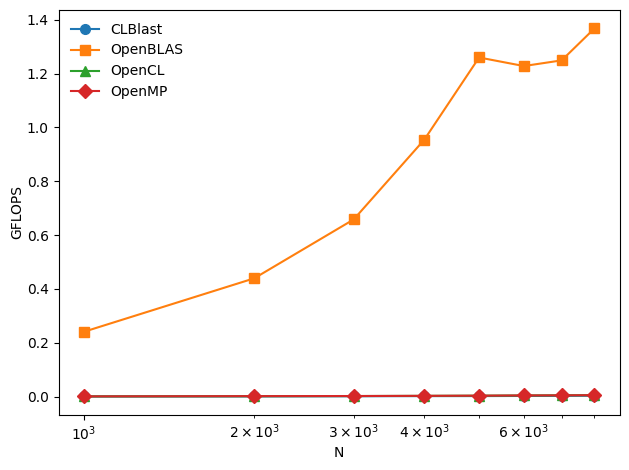

In [58]:
plot_metrics(dot_df[dot_df["dtype"] == "float"].groupby("runtime"), xlabel="N", ylabel="GFLOPS")

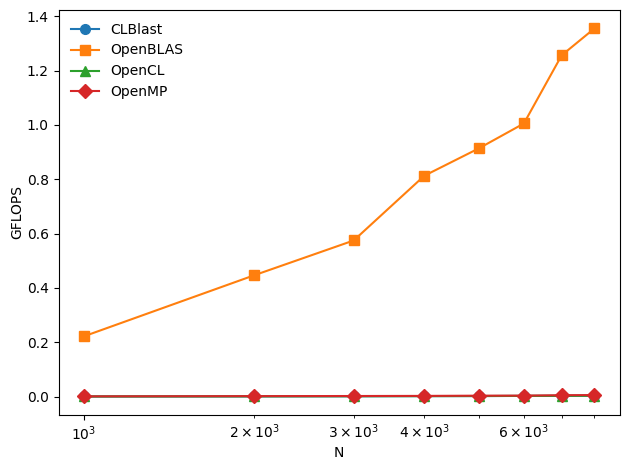

In [59]:
plot_metrics(dot_df[dot_df["dtype"] == "double"].groupby("runtime"), xlabel="N", ylabel="GFLOPS")

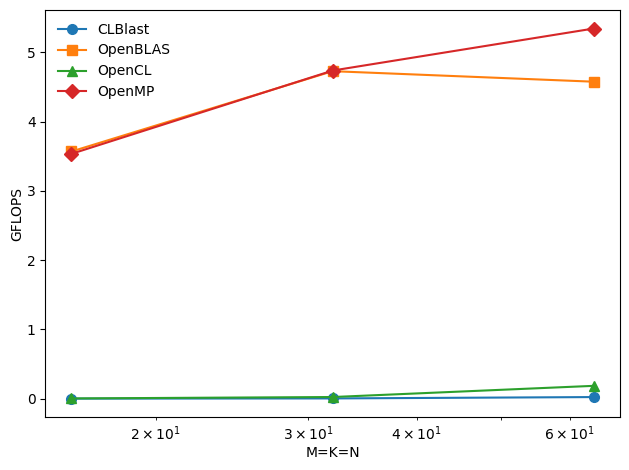

In [60]:
plot_metrics(gemms_df[gemms_df["dtype"] == "float"].groupby("runtime"), xlabel="M=K=N", ylabel="GFLOPS")

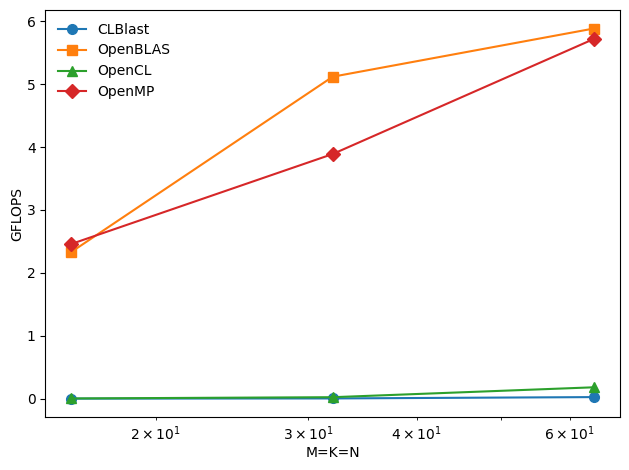

In [61]:
plot_metrics(gemms_df[gemms_df["dtype"] == "double"].groupby("runtime"), xlabel="M=K=N", ylabel="GFLOPS")